In [2]:
import pickle

from ema_workbench import (
    Model,
    MultiprocessingEvaluator,
    ScalarOutcome,
    IntegerParameter,
    optimize,
    Scenario,
    save_results,
    load_results,
)

from ema_workbench.em_framework.optimization import (ArchiveLogger,
                                                     EpsilonProgress)

from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench.util import ema_logging

from problem_formulation import get_model_for_problem_formulation
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

## Multi-Scenario MORDM
In the following Jupyter notebook, we walk through the process of multi-scenario MORDM. We do this to test optimal policies that comply with our own goals and result in favorouble policy outcomes. We start the process by following steps, outlined and explained at each step.

### Step 1: Problem formulation
We start simply with problem formulation. We call up our functions and determine the reference values with which we will start optimizing. Running this code takes a long time, therefore we have saved our runs in the archives folder. The parts where the results are generated are commented out so as not to accidentally run these.


In [3]:
ema_logging.log_to_stderr(ema_logging.INFO)

model, steps = get_model_for_problem_formulation(2)

reference_values = {
        "Bmax": 175,
        "Brate": 1.5,
        "pfail": 0.5,
        "discount rate 0": 3.5,
        "discount rate 1": 3.5,
        "discount rate 2": 3.5,
        "discount rate 3": 3.5,
        "ID flood wave shape": 4,
    }

scen1 = {}

for key in model.uncertainties:
    name_split = key.name.split("_")
    if len(name_split) == 1:
        scen1.update({key.name: reference_values[key.name]})
    else:
        scen1.update({key.name: reference_values[name_split[1]]})

ref_scenario = Scenario("reference", **scen1)

In [4]:
# list_results = []
# list_convergences = []

# with MultiprocessingEvaluator(model) as evaluator:
#     # run for 4 seeds
#     for i in range(4):
#         convergence_metrics = [EpsilonProgress(),]
#
#         with MultiprocessingEvaluator(model) as evaluator:
#             result, convergence = evaluator.optimize(
#                     nfe=40000,
#                     searchover="levers",
#                     epsilons=[0.01,]*len(model.outcomes),
#                     convergence=convergence_metrics,
#                     reference=ref_scenario,
#                 )
#         list_results.append(result)
#         list_convergences.append(convergence)
#
# with open("./archives/store_results", "wb") as fp:
#     pickle.dump(list_results, fp)
# with open("./archives/store_convergences","wb") as fp:
#     pickle.dump(list_convergences,fp)

In [5]:
# This code loads our saved lists with the results and convergences for all 4 seeds

with open("./archives/store_results", "rb") as fp:   # Unpickling
    list_results = pickle.load(fp)

with open("./archives/store_convergences", "rb") as fp:   # Unpickling
    list_convergences = pickle.load(fp)

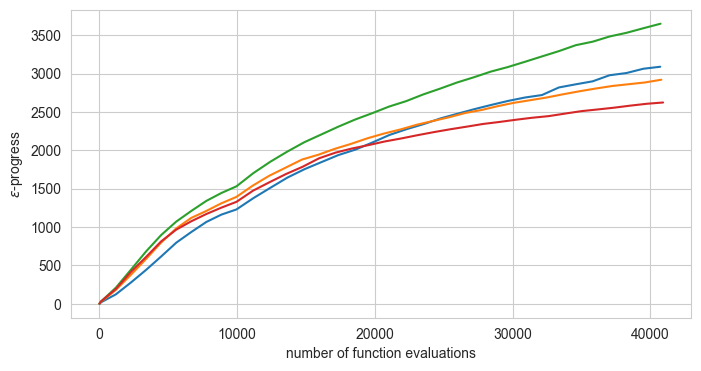

In [6]:
fig, ax = plt.subplots(figsize=(8,4))
for i in range(4):
    ax.plot(list_convergences[i].nfe, list_convergences[i].epsilon_progress)
    ax.set_ylabel('$\epsilon$-progress')
    ax.set_xlabel('number of function evaluations')
plt.show()

The above plot demonstrates the convergence of running 40.000 nfes. Although it doesn't really seem like they converge, we must accept that this is the best we will get within the time constraints.

### Step 2: Searching for candidate solutions
The next step we will use the devised policies from the optimization to determine the best results. We concatinate all obtained results from the 4 seeds we ran, and we filter these based on criteria most relevant for our actor. This is summarized as:
* No room for river in locations 1 and 2
* Dike heightening of at least 0.3m in dike 1
* Average dike heightening across all dikes greater than 4.2

In [7]:
results = pd.concat(list_results)

In [8]:
results['room for river 1 & 2'] = results.loc[:, '0_RfR 0':'1_RfR 3'].sum(axis=1)
results['dike heightening 1'] = results.loc[:, 'A.1_DikeIncrease 0':'A.1_DikeIncrease 3'].sum(axis=1)
results['average heightening'] = results.loc[:, 'A.1_DikeIncrease 0':'A.4_DikeIncrease 3'].sum(axis=1) / 5

In [9]:
selection = results[results['room for river 1 & 2'] == 0]
selection = selection[selection['dike heightening 1'] >= 3]
final_selection = selection[selection['average heightening'] > 4.2]

In [10]:
policies = final_selection.loc[:, '0_RfR 0':'A.5_DikeIncrease 3']

In [11]:
print(f'We continue with {len(policies)} policies.')

We continue with 6 policies.


### Step 3: Re-evaluate candidate solutions under uncertainty
With these 6 obtained policies, we move on to the next step, performing experiments. We take the 6 policies and test them in 1000 scenarios. We then use the results to test the robustness.

In [12]:
from ema_workbench import Policy

policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [13]:
# n_scenarios = 1000
# with MultiprocessingEvaluator(model) as evaluator:
#     results = evaluator.perform_experiments(n_scenarios,
#                                             policies_to_evaluate)
# save_results(results, "./archives/mordm_step3.tar.gz")

In [14]:
results = load_results('./archives/mordm_step3.tar.gz')

[MainProcess/INFO] results loaded successfully from /Users/emmavankleef/Documents/Master/Jaar_2/Periode_4/EPA1361_Final_Group4/archives/mordm_step3.tar.gz


##### Robustness metrics
We use two robustness metrics to test the 6 given policies.

**Signal to noise**
The first robustness metric is the *signal-to-noise ratio*, in the case of minimization (as all our metrics) is the mean multiplied by the standard deviation. A low average value with low standard deviation is preferred, therefore we want to maximize the signal-to-noise ratio.

In [15]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)

    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [16]:
experiments, outcomes = results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy']==policy

    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
8,3.836334e+17,0.000000,0.0,0.000000e+00,0.381471
58,3.290426e+17,0.000000,0.0,0.000000e+00,0.225580
71,3.704430e+17,20.471276,0.0,0.000000e+00,0.330068
145,3.268088e+17,6.904159,0.0,0.000000e+00,0.226567
340,3.275604e+17,11.426302,0.0,7.521286e+07,0.004767
394,3.460925e+17,6.914084,0.0,0.000000e+00,0.281502


/Users/emmavankleef/Documents/Master/Jaar_2/Periode_4/EPA1361_Final_Group4/venv/lib/python3.10/site-packages/ema_workbench/analysis/prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive " "inspection not available"), ImportWarning)


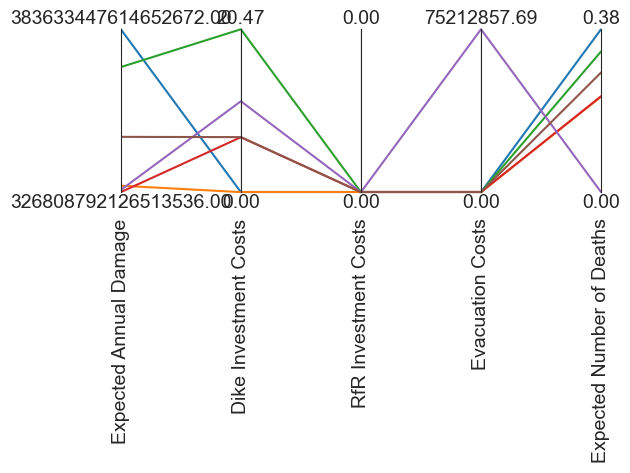

In [17]:
from ema_workbench.analysis import parcoords

data = scores
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

<What does the above tell me?>

**Max regret**
The second robustness metric is maximum regret. This is calculated for each policy and its outcome. It is defined for each policy as the difference between the performance of the policy in a specific scenario, and the performance of a no-regret (the best possible result in that scnario) or reference policy. The max regret is then the maximum of such regret values across all scenarios. The favorable policy is one with low max-regret values.

In [18]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [19]:
experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']
    data = pd.DataFrame({outcome.name: outcomes[outcome.name],
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})

    data = data.pivot(index='scenario', columns='policy')

    data.columns = data.columns.get_level_values(1)
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()


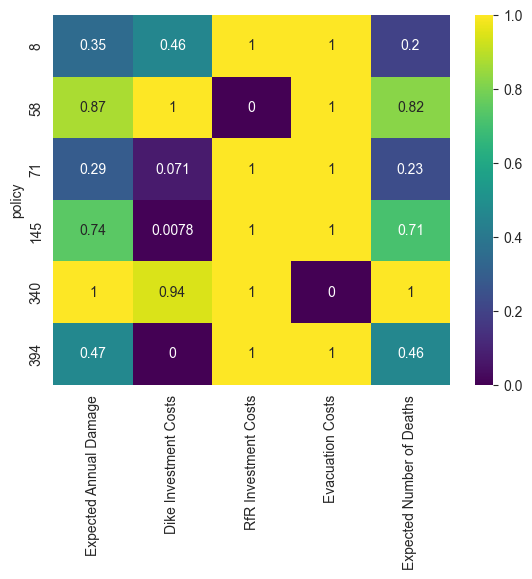

In [20]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

In terms of RfR investment costs and evacuation costs, only one policy is more favourable compared to the rest, but either policies are not better off in general. Looking only generally at low values, policy 8 is probably the best one, but it is still hard to tell.

### Step 4: Scenario discovery
In this step we use PRIM to determine which scenarios are most interesting to explore. We choose a set of scenarios that has a high density and coverage to then look at which are best and which are worst. The chosen scenarios will then be used for the next step.

In [21]:
x = experiments.loc[:, :'discount rate 3']

In [22]:
outcomes['Expected Annual Damage'].sort()

In [23]:
np.percentile(outcomes['Expected Annual Damage'],10)

1225955.8285727615

In [24]:
from ema_workbench.analysis import prim

x = experiments.iloc[:, :-3]
y = outcomes['Expected Annual Damage'] < np.percentile(outcomes['Expected Annual Damage'],10)

prim_alg = prim.Prim(x, y, threshold=0.5, peel_alpha=0.005)
box = prim_alg.find_box()

[MainProcess/INFO] 6000 points remaining, containing 600 cases of interest
[MainProcess/INFO] mean: 0.6615384615384615, mass: 0.07583333333333334, coverage: 0.5016666666666667, density: 0.6615384615384615 restricted_dimensions: 11


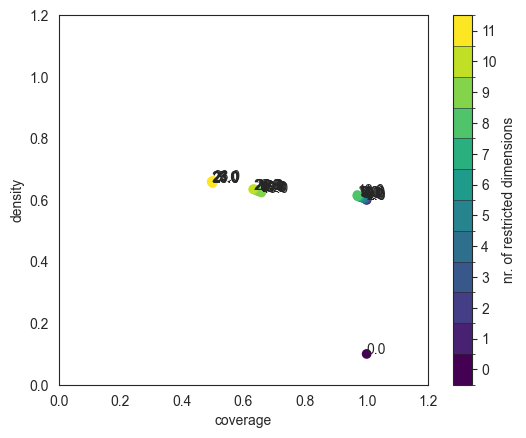

In [25]:
box.show_tradeoff(annotated=True)
plt.show()

In [26]:
box.inspect(13)

coverage     0.658333
density      0.624013
id          13.000000
mass         0.105500
mean         0.624013
res_dim      9.000000
Name: 13, dtype: float64

              box 13                                     
                 min         max       qp value  qp value
A.3_Brate   1.000000    5.750000            NaN  0.352926
A.4_pfail   0.000646    0.994922            NaN  0.509620
2_RfR 0     1.000000    1.000000  8.596356e-220       NaN
A.5_Bmax   33.199884  349.813331   3.976308e-01       NaN
A.3_Bmax   31.651515  349.726057   4.490401e-01       NaN
A.4_Bmax   31.522017  349.793759   4.490401e-01       NaN
A.2_Bmax   31.685771  348.381156   4.690944e-01  0.469094
A.1_Bmax   31.518788  348.443728   5.096195e-01  0.489304
A.2_pfail   0.010042    0.999505   5.218784e-01       NaN



[None]

In [27]:
box.select(13)

box_scenarios = experiments.iloc[box.yi]
box_outcomes = {k:v[box.yi] for k,v in outcomes.items()}

We select box 13 and use this box to determing **best and worst case** scenarios to explore.

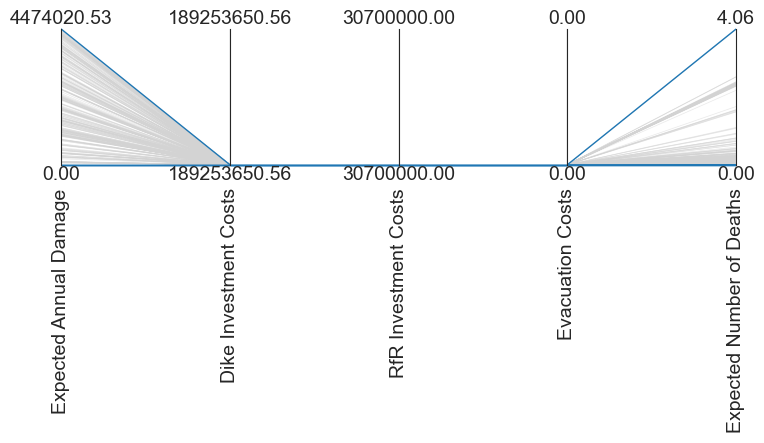

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench.analysis import parcoords

# conditional on y
all_data = pd.DataFrame({k:v for k,v in box_outcomes.items()})

# let's get the unique indices for the minima and maxima across
# all objectives
indices = pd.concat([all_data.idxmax(), all_data.idxmin()]).unique()

limits = parcoords.get_limits(all_data)
axes = parcoords.ParallelAxes(limits)

# we set the linewidth lower, and make the lines slightly transpartant using alpha
# this often helps reveal patterns in the results.
axes.plot(all_data, color='lightgrey', lw=0.5, alpha=0.5)
axes.plot(all_data.iloc[indices, :], color=sns.color_palette()[0], lw=1)

fig = plt.gcf()
fig.set_size_inches((8, 4))

plt.show()

In [29]:
print(all_data.idxmax())
print(all_data.idxmin())

Expected Annual Damage       632
Dike Investment Costs          0
RfR Investment Costs           0
Evacuation Costs               0
Expected Number of Deaths    273
dtype: int64
Expected Annual Damage       0
Dike Investment Costs        0
RfR Investment Costs         0
Evacuation Costs             0
Expected Number of Deaths    1
dtype: int64


In [30]:
selected = experiments.loc[[711,317,2]]

In [31]:
selected

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.4_DikeIncrease 3,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,A.5_DikeIncrease 3,scenario,policy,model
711,23,284.833367,1.0,0.872368,313.256712,1.0,0.606817,99.320365,10.0,0.702795,...,0,0,5,7,0,0,0,1711,58,dikesnet
317,68,100.035570,10.0,0.636096,318.397255,1.5,0.582602,227.935943,1.5,0.511982,...,0,0,5,7,0,0,0,1317,58,dikesnet
2,120,327.344187,1.5,0.631261,151.997870,1.5,0.674188,298.789134,1.5,0.777554,...,0,0,5,7,0,0,0,1002,58,dikesnet


In [32]:
from ema_workbench import Scenario

scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]

Using the best and worst case we end up with 3 scenarios that are interesting for re-optimization.

### Step 5: Re-optimization with newfound scenarios
We use the above three scenarios and run the optimization for 2 seeds each, resulting in 6 runs.


In [57]:
def run_scenario(scenario):
    list_results = []
    list_convergences = []
    for i in range(2):
        convergence_metrics = [EpsilonProgress()]
        with MultiprocessingEvaluator(model) as evaluator:
            result, convergence = evaluator.optimize(
                    nfe=40000,
                    searchover="levers",
                    epsilons=[0.01,]*len(model.outcomes),
                    convergence=convergence_metrics,
                    reference=scenario,
                )
        list_results.append(result)
        list_convergences.append(convergence)

    return pd.concat(list_results), list_convergences
#
# list_of_results = []
# for scenario in scenarios:
#     list_of_results.append(run_scenario(scenario))
#
# with open("./archives/store_mordm_step5", "wb") as fp:
#     pickle.dump(list_of_results, fp)

In [58]:
# We use pickle again to load the list from the archives

with open("./archives/store_mordm_step5", "rb") as fp:   # Unpickling
    list_of_results = pickle.load(fp)

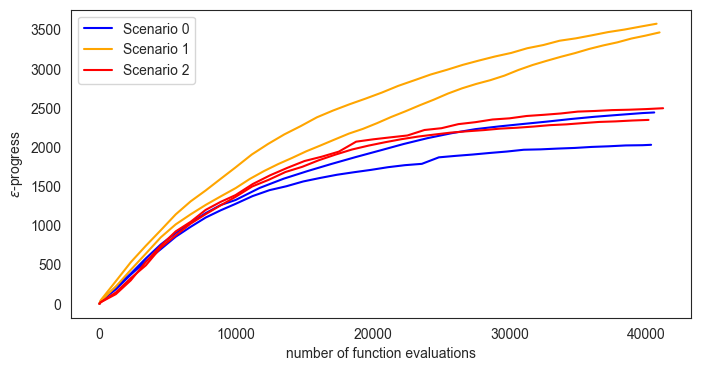

In [59]:
colors = ['blue','orange','red']
fig, ax = plt.subplots(figsize=(8,4))
for i in range(3):
    ax.plot(list_of_results[i][1][0].nfe, list_of_results[i][1][0].epsilon_progress,
            color=colors[i])
    ax.plot(list_of_results[i][1][1].nfe, list_of_results[i][1][1].epsilon_progress,
            label=f"Scenario {i}", color=colors[i])
ax.set_ylabel('$\epsilon$-progress')
ax.set_xlabel('number of function evaluations')
ax.legend()
plt.show()

< comment on the convergence of the above >

### Step 6: Run experiments with new policies
We filter our policies once again on the same criteria as in step 2 and use these to run experiments.

In [60]:
results = pd.concat([results for results, _ in list_of_results])

In [61]:
results['room for river 1 & 2'] = results.loc[:, '0_RfR 0':'1_RfR 3'].sum(axis=1)
results['dike heightening 1'] = results.loc[:, 'A.1_DikeIncrease 0':'A.1_DikeIncrease 3'].sum(axis=1)
results['average heightening'] = results.loc[:, 'A.1_DikeIncrease 0':'A.4_DikeIncrease 3'].sum(axis=1) / 5

In [62]:
selection = results[results['room for river 1 & 2'] == 0]
selection = selection[selection['dike heightening 1'] >= 3]
final_selection = selection[selection['average heightening'] > 4.2]

In [63]:
policies = final_selection.loc[:, '0_RfR 0':'A.5_DikeIncrease 3']

In [64]:
print(f'We continue with {len(policies)} policies.')

We continue with 5 policies.


In [65]:
from ema_workbench import Policy

policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [76]:
# with MultiprocessingEvaluator(model) as evaluator:
#     reeevaluation_results = evaluator.perform_experiments(1000, policies=policies_to_evaluate)
#
# with open("./archives/store_reeevaluation_results", "wb") as fp:
#     pickle.dump(reeevaluation_results, fp)

In [77]:
# We use pickle again to load the list from the archives

with open("./archives/store_reeevaluation_results", "rb") as fp:   # Unpickling
    reeevaluation_results = pickle.load(fp)

### Step 7: Test robustness of policies
Finally, we arrive at the last step, where we use the same two robustness metrics to determine how robust the new policies are.

**Signal-to-noise**

In [72]:
# This is not signal to noise

experiments, outcomes = reeevaluation_results

overall_scores = {}
for policy in experiments.policy.unique():
    logical = experiments.policy == policy
    scores = {}
    for k, v in outcomes.items():
        try:
            n = np.sum(v[logical]>=0.9)
        except KeyError:
            continue
        scores[k] = n/1000
    overall_scores[policy] = scores

overall_scores = pd.DataFrame(overall_scores).T

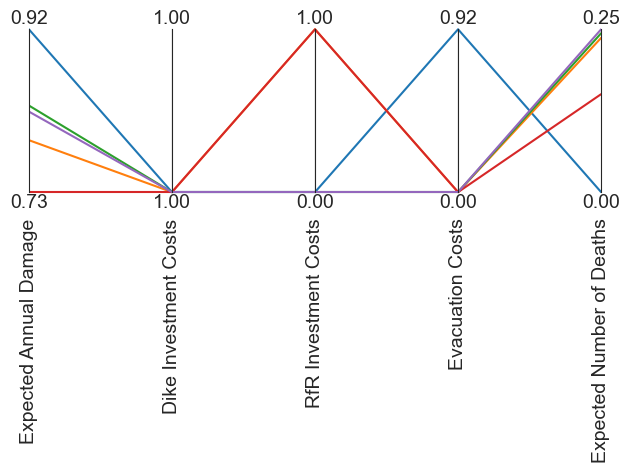

In [73]:
limits = parcoords.get_limits(overall_scores)
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(overall_scores)
plt.show()

**Max regret**

In [74]:
experiments, outcomes = reeevaluation_results

outcomes = pd.DataFrame(outcomes)
outcomes['scenario'] = experiments.scenario
outcomes['policy'] = experiments.policy

def calculate_regret(x):
    # policy is non numeric, so max is not defined for this
    best = x.max(numeric_only=True)
    regret = best -x.loc[:, best.index]
    # we add policy back into our regret dataframe
    # so we know the regret for each policy
    regret['policy'] = x.policy
    return regret

# we want to calculate regret on a scenario by scenario basis
regret = outcomes.groupby('scenario', group_keys=False).apply(calculate_regret)

# as last step, we calculate the maximum regret for each policy
max_regret = regret.groupby('policy').max()

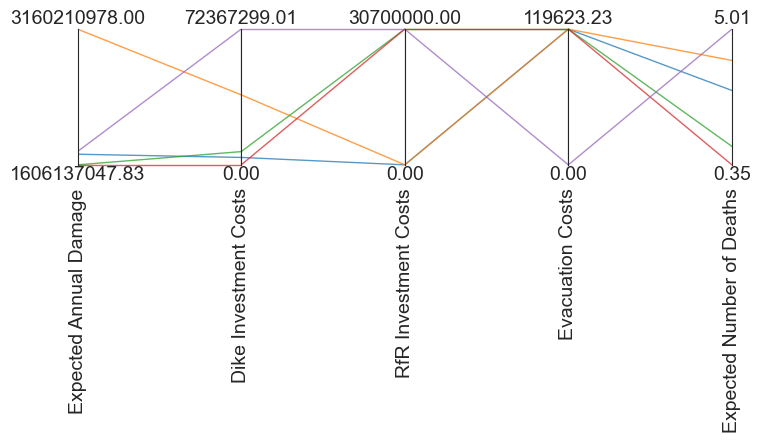

In [75]:
# I reorder the columns
limits = parcoords.get_limits(max_regret)
paraxes = parcoords.ParallelAxes(max_regret)
paraxes.plot(max_regret, lw=1, alpha=0.75)

# let's resize the figure a bit
fig = plt.gcf()
fig.set_size_inches(8, 4)

plt.show()